### Manifold Mixup for Speaker Verification

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import re
import kaldiio
from kaldiio import ReadHelper
import seaborn as sns

import torch
import torch.utils.data as data
import os
import torch.nn as nn

from matplotlib.collections import PolyCollection
from scipy.interpolate import make_interp_spline
from scipy import stats
import pandas as pd
from Misc.analysis import format_eer_file, read_eer_file, format_eer_file_train, format_eer_file_eval

script_dir = '/home/yangwenhao/local/project/SpeakerVerification-pytorch'
lstm_dir = '/home/yangwenhao/local/project/lstm_speaker_verification'

#### I. Methold

1. Manifold Mixup Schemes

* Input Mixup
* Medium Mixup
* Embeddings Mixup   ---- Dummy Classifiers ?

2. Domain Mixup



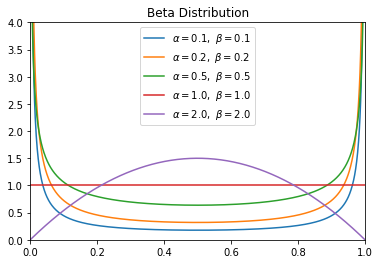

In [44]:
plt.figure(figsize=(6, 4))

ab_pairs = [(0.1, 0.1), (0.2, 0.2), (0.5, 0.5), (1, 1), (2, 2)]
x = np.linspace(0, 1, 1002)[1:-1]
for a, b in ab_pairs:
    # print(a,b)
    dist= beta(a, b)
    y = dist.pdf(x)
    plt.plot(x, y, label=r'$\alpha=%.1f,\ \beta=%.1f$'%(a, b))
plt.title(u'Beta Distribution')
plt.xlim(0,1)
plt.ylim(0,4)
plt.legend()

# plt.savefig("./beta.png", format="png")

#### II. Experiment

1. Comparison of $\alpha, \beta$  in Beta Distribution 

* Training set: VoxCeleb1

| System      |  Beta(alpha)  |       Testset     |     EER     |    MinDCF08   |    MinDCF10   |
| :---------- | :-----------: | :---------------: | ----------: | ------------: | ------------: |
|  ResNet34   |   baseline    |     vox1-test     |  3.66±0.08  | 0.3703±0.0248 | 0.4460±0.0231 |
|     0.1     |      0.1      |     vox1-test     |  4.05±0.04  | 0.3961±0.0076 | 0.4839±0.0299 |
|     0.2     |      0.2      |     vox1-test     |  4.09±0.05  | 0.3876±0.0100 | 0.5330±0.0131 |
|     0.5     |      0.5      |     vox1-test     |  4.26±0.04  | 0.4033±0.0139 | 0.4873±0.0125 |
|     1.0     |      1.0      |     vox1-test     |  4.26±0.04  | 0.4033±0.0139 | 0.4873±0.0125 |
|     2.0     |      2.0      |     vox1-test     |  4.26±0.04  | 0.4033±0.0139 | 0.4873±0.0125 |


2. Comparison of Mixup Layers 

* Training set: VoxCeleb1

| System      |  Description  |       Testset     |     EER     |    MinDCF08   |    MinDCF10   |
| :---------- | :-----------: | :---------------: | ----------: | ------------: | ------------: |
|  ResNet34   |   baseline    |     vox1-test     |  3.66±0.08  | 0.3703±0.0248 | 0.4460±0.0231 |
|     {0}     |               |     vox1-test     |  4.05±0.04  | 0.3961±0.0076 | 0.4839±0.0299 |
|    {0,1}    |               |     vox1-test     |  4.09±0.05  | 0.3876±0.0100 | 0.5330±0.0131 |
|   {0,1,2}   |               |     vox1-test     |  4.26±0.04  | 0.4033±0.0139 | 0.4873±0.0125 |


2. Validation on Large-Scale Dataset

* Training set: VoxCeleb2

| System      |  Description  |       Testset     |     EER     |    MinDCF08   |    MinDCF10   |
| :---------- | :-----------: | :---------------: | ----------: | ------------: | ------------: |
|  ResNet34   |    baseline   |     vox1-test     |  3.66±0.08  | 0.3703±0.0248 | 0.4460±0.0231 |
|             |     Input     |     vox1-test     |  4.25±0.10  | 0.3914±0.0040 | 0.5287±0.0207 |
|             |   manifold    |     vox1-test     |  4.05±0.04  | 0.3961±0.0076 | 0.4839±0.0299 |
|             |               |     vox1-test     |  4.09±0.05  | 0.3876±0.0100 | 0.5330±0.0131 |
|             |               |     vox1-test     |  4.26±0.04  | 0.4033±0.0139 | 0.4873±0.0125 |
|    ECAPA    |               |     vox1-test     |  3.66±0.08  | 0.3703±0.0248 | 0.4460±0.0231 |
|             |      Input    |     vox1-test     |  4.25±0.10  | 0.3914±0.0040 | 0.5287±0.0207 |
|             |   manifold    |     vox1-test     |  4.05±0.04  | 0.3961±0.0076 | 0.4839±0.0299 |
|             |               |     vox1-test     |  4.09±0.05  | 0.3876±0.0100 | 0.5330±0.0131 |
|             |               |     vox1-test     |  4.26±0.04  | 0.4033±0.0139 | 0.4873±0.0125 |
 




In [11]:
results = format_eer_file_eval('../data/vox1_clsaug_128.txt', log=False)
models = ['baseline', 
          r'mixup-manifold[1-9]$', 
          r'mixup-manifold[1-9]-clsaug', 
          r'mixup-manifold[1-9]-lamdba=0.2', 
          r'mixup-manifold[1-9]-lamdba=0.2-mix_ratio=0.5', 
          r'mixup-manifold[1-9]-lamdba=0.2-mix_ratio=0.75']

layers = [i for i in range(9)]

result_type = {}
eval_type = {'eer':1, 'mindcf08': 2, 'mindcf10': 3, 'mix2': 4, 'mix3': 5,}
eval_index = eval_type['eer']

for l in results:
    if models[0] in l[0]:
        result_type[models[0]]=[[i, l[eval_index]] for i in range(9)]
    elif re.match(models[1], l[0]) != None:
        if l[0][:-1] not in result_type:
            result_type[l[0][:-1]]=[[int(l[0][-1]), l[eval_index]]]
        else:
            result_type[l[0][:-1]].append([int(l[0][-1]), l[eval_index]])
    else:
        this_type = l[0].split('-')[-1]
        if this_type not in result_type:
            result_type[this_type]=[[int(l[0][14]), l[eval_index]]]
        else:
            result_type[this_type].append([int(l[0][14]), l[eval_index]])

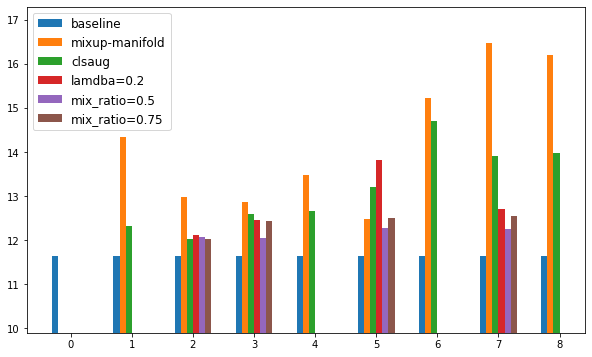

In [14]:
plt.figure(figsize=(10, 6))

types = list(result_type.keys())
x = np.array([i*0.1 for i in range(len(types))])-0.25
max_y,min_y = 0,100

for i, this_type in enumerate(types):
    r = np.array(result_type[this_type])
    plt.bar(r[:, 0]+x[i], r[:, 1], width=0.1)
    max_y = max(max_y, np.max(r[:, 1]))
    min_y = min(min_y, np.min(r[:, 1]))
    # plt.plot(r[:, 0], r[:, 1], marker='.')

plt.ylim([min_y*0.85, max_y*1.05])
plt.xticks(np.arange(9))
plt.legend(types, fontsize=12)

Text(0, 0.5, 'EER (%)')

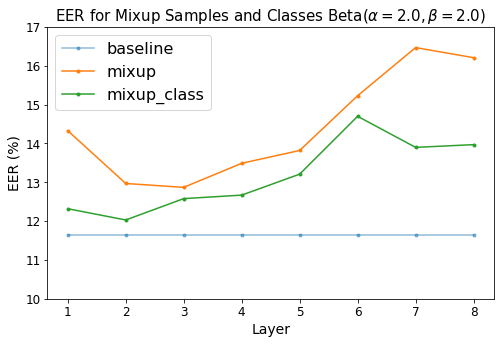

In [43]:
fig = plt.figure(figsize=(8, 5))
plt.title(u'EER for Mixup Samples and Classes Beta($\\alpha=2.0,\\beta=2.0$)', fontsize=15)

x = np.arange(1,9)
plt.plot(x, [baseline]*len(x), marker='.', alpha=0.5)
plt.plot(x, mixup, marker='.')
plt.plot(x, cls_aug, marker='.')
plt.legend(['baseline', 'mixup', 'mixup_class'], fontsize=16)
plt.ylim([10, 17])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Layer', fontsize=14)
plt.ylabel('EER (%)', fontsize=14)

In [2]:
epoch = 46    
ckp_path = script_dir + '/Data/checkpoint/ThinResNet34/vox1/klfb_egs_baseline/arcsoft_sgd_step/Mean_batch256_seblock_red2_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wd5e4_varesmix2_bashuf2_dist_cnc_core/percent0.5_random/123456/checkpoint_%d.pth' % epoch

if os.path.exists(ckp_path):
    ckp = torch.load(ckp_path)
    model_dict = ckp['state_dict']
    center = model_dict['classifier.W'].cpu()

In [4]:
mix_centers = []
center_norm = center/center.norm(p=2, dim=0)

for i in range(796):
    center_1 = center_norm[:, i].reshape(-1,1)
    other_center = center_norm[:, i+1:]

    mix_center = (center_1 + other_center)/2
    mix_center_norm = mix_center / mix_center.norm(p=2, dim=0)
    mix_centers.append(mix_center_norm)
    
mix_centers = torch.cat(mix_centers, dim=1)  
mix_centers_norm = mix_centers/mix_centers.norm(p=2, dim=0)
print(mix_centers.shape)

center_ag = torch.matmul(center_norm.T, mix_centers_norm)
print(center_ag.shape)

torch.Size([256, 317206])
torch.Size([797, 317206])


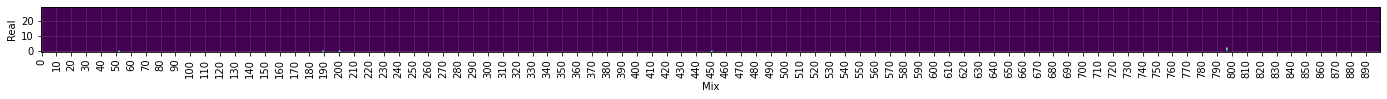

In [36]:
plt.figure(figsize=(24, 8))
# [:20, :20]
numofcenters= 900
real_centers = 30

sim = (center_ag[:real_centers, :numofcenters]>0.8).cpu().numpy()
# sim = np.flip(sim, axis=0)
plt.imshow(sim, origin='lower')
# plt.imshow((center_ag[:real_centers, :numofcenters]).cpu().T)

_ = plt.yticks(np.arange(0, real_centers, 10))
_ = plt.xticks(np.arange(0, numofcenters, 10), rotation=90,)
# _ = plt.xticks(np.arange(11), domains, rotation=30, fontsize=16)
# plt.xlim([800, 900])
plt.xlabel('Mix')
plt.ylabel('Real')

plt.grid(alpha=0.2)
# sns.kdeplot((center_ag[:numofcenters, :numofcenters]>0.1).sum(dim=0).view(-1).cpu().numpy())
# plt.plot((center_ag[:, :numofcenters]>0.2).sum(dim=0).view(-1).cpu().numpy())